In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import math

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import *
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from keras_core import callbacks
import keras_core
#from keras_core import layers
#from keras_core import optimizers
from keras import layers
from keras import optimizers
import keras_tuner
from tensorflow_probability import distributions as tfd
from scipy.stats import linregress


#### Data pre-process and visualization

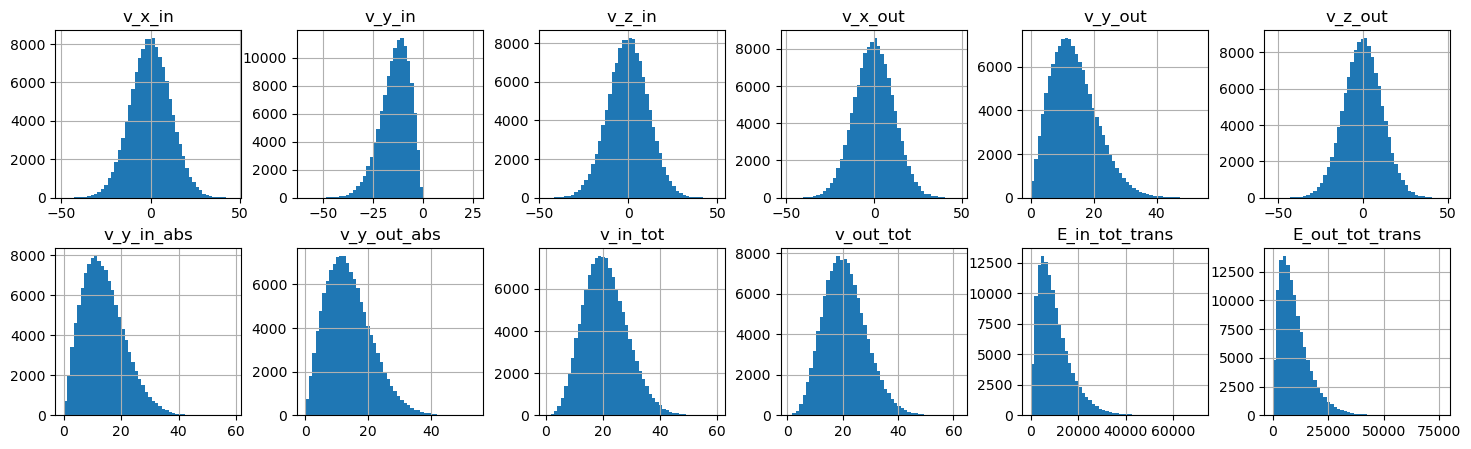

In [57]:
filename = 'D:/OneDrive - TU Eindhoven/Quartile_4/4AI000_Machine learning for Multi-physics modelling and design/Materials_for_ML_assignment_2024/H2_IsoThermalWalls_Sw_0/H2_Vel_MD_Sw_0_B300_Th_300.txt'
names_trans_vel = ['v_x_in', 'v_y_in', 'v_z_in', 'v_x_out', 'v_y_out', 'v_z_out']
df_trans_vel = pd.read_csv(filename, sep= '\s+', header=None, skiprows=[0], names = names_trans_vel).sample(frac = 1)

names_trans_vel = ['v_x_in', 'v_y_in', 'v_z_in', 'v_x_out', 'v_y_out', 'v_z_out']
df_trans_vel = pd.read_csv(filename, sep= '\s+', header=None, skiprows=[0], names = names_trans_vel).sample(frac = 1)


MASS_AR= 39.948

# Creating columns for overall velocities
df_trans_vel['v_y_in_abs'] = np.absolute(df_trans_vel["v_y_in"])
df_trans_vel['v_y_out_abs'] = np.absolute(df_trans_vel["v_y_out"])
df_trans_vel['v_in_tot'] = (np.power(df_trans_vel["v_x_in"],2)+ np.power(df_trans_vel["v_y_in"],2) + np.power(df_trans_vel["v_z_in"],2))**0.5
df_trans_vel['v_out_tot'] = (np.power(df_trans_vel["v_x_out"],2)+ np.power(df_trans_vel["v_y_out"],2) + np.power(df_trans_vel["v_z_out"],2))**0.5
df_trans_vel['E_in_tot_trans'] = (0.5 * MASS_AR * (np.power(df_trans_vel["v_x_in"],2)+ np.power(df_trans_vel["v_y_in"],2) + np.power(df_trans_vel["v_z_in"],2)))
df_trans_vel['E_out_tot_trans'] = (0.5 * MASS_AR * (np.power(df_trans_vel["v_x_out"],2)+ np.power(df_trans_vel["v_y_out"],2) + np.power(df_trans_vel["v_z_out"],2)))


x = df_trans_vel.loc[:, ].values
x_norm = MinMaxScaler().fit_transform(x) # normalizing the features


# Plot the data
df_trans_vel.hist(bins = 50, layout= (2,6), figsize= (18,5))

names_trans_vel_norm = ['v_x_in', 'v_y_in', 'v_z_in', 'v_x_out', 'v_y_out', 'v_z_out', 'v_y_in_abs', 'v_y_out_abs', 'v_in_tot','v_out_tot', 'E_in_tot_trans', 'E_out_tot_trans']

# Normalization
df_trans_vel_norm = pd.DataFrame(x_norm,columns=names_trans_vel_norm)


x = df_trans_vel_norm[['v_x_in']].to_numpy()
y = df_trans_vel_norm[['v_x_out']].to_numpy()

In [58]:
y.shape

(123351, 1)

### Selected components 

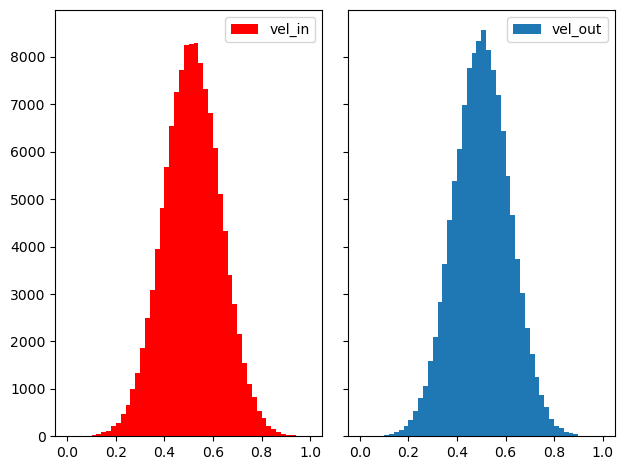

In [59]:
n_bins = 50

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(x, bins=n_bins, label = 'vel_in', color = 'r')
axs[1].hist(y, bins=n_bins, label = 'vel_out')
axs[0].legend()
axs[1].legend()
plt.show()

In [60]:
sns.scatterplot(df_trans_vel_norm, x = "vel_in", y = 'vel_out')

ValueError: Could not interpret value `vel_in` for `x`. An entry with this name does not appear in `data`.

In [ ]:
def elu_plus_one_plus_epsilon(x):
    return keras_core.activations.elu(x) + 1 + keras_core.backend.epsilon()

class MixtureDensityOutput(layers.Layer):
    def __init__(self, output_dimension, num_mixtures, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dimension
        self.num_mix = num_mixtures
        self.mdn_mus = layers.Dense(
            self.num_mix * self.output_dim, name="mdn_mus"
        )  # mix*output vals, no activation
        self.mdn_sigmas = layers.Dense(
            self.num_mix * self.output_dim,
            activation=elu_plus_one_plus_epsilon,
            name="mdn_sigmas",
        )  # mix*output vals exp activation
        self.mdn_pi = layers.Dense(self.num_mix, name="mdn_pi")  # mix vals, logits

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        super().build(input_shape)

    @property
    def trainable_weights(self):
        return (
            self.mdn_mus.trainable_weights
            + self.mdn_sigmas.trainable_weights
            + self.mdn_pi.trainable_weights
        )

    @property
    def non_trainable_weights(self):
        return (
            self.mdn_mus.non_trainable_weights
            + self.mdn_sigmas.non_trainable_weights
            + self.mdn_pi.non_trainable_weights
        )

    def call(self, x, mask=None):
        return layers.concatenate(
            [self.mdn_mus(x), self.mdn_sigmas(x), self.mdn_pi(x)], name="mdn_outputs"
        )
    
def get_mixture_loss_func(output_dim, num_mixes):
    def mdn_loss_func(y_true, y_pred):
        # Reshape inputs in case this is used in a TimeDistributed layer
        y_pred = tf.reshape(
            y_pred,
            [-1, (2 * num_mixes * output_dim) + num_mixes],
            name="reshape_ypreds",
        )
        y_true = tf.reshape(y_true, [-1, output_dim], name="reshape_ytrue")
        # Split the inputs into parameters
        out_mu, out_sigma, out_pi = tf.split(
            y_pred,
            num_or_size_splits=[
                num_mixes * output_dim,
                num_mixes * output_dim,
                num_mixes,
            ],
            axis=-1,
            name="mdn_coef_split",
        )
        # Construct the mixture models
        cat = tfd.Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [
            tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale)
            for loc, scale in zip(mus, sigs)
        ]
        mixture = tfd.Mixture(cat=cat, components=coll)
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        loss = tf.reduce_mean(loss)
        return loss

    return mdn_loss_func




#### Build and compile model

In [ ]:
N_HIDDEN = 32

OUTPUT_DIMS = 1
N_MIXES = 20


mdn_network1 = keras.Sequential(
    [
        layers.Dense(N_HIDDEN, activation="relu"),
        layers.Dense(N_HIDDEN, activation="relu"),
        MixtureDensityOutput(OUTPUT_DIMS, N_MIXES),
    ]
)

mdn_network2 = keras.Sequential(
    [
        layers.Dense(N_HIDDEN, activation="relu"),
        layers.Dense(N_HIDDEN, activation="relu"),
        MixtureDensityOutput(OUTPUT_DIMS, N_MIXES),
    ]
)

loss_function = get_mixture_loss_func(OUTPUT_DIMS, N_MIXES)
optimizer = "adam"

mdn_network1.compile(loss= loss_function, optimizer= optimizer)
mdn_network2.compile(loss= loss_function, optimizer= optimizer)


### Training the MDN

In [ ]:
history = mdn_network1.fit(
    x,
    y,
    epochs=100,
    batch_size = 256,
    validation_split=0.15,
    shuffle = True,
    callbacks=[
        callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="loss", patience=5),
    ],
)

Epoch 1/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0850 - val_loss: -1.3482 - learning_rate: 0.0010
Epoch 2/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: -1.3887 - val_loss: -1.3901 - learning_rate: 0.0010
Epoch 3/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: -1.4000 - val_loss: -1.4031 - learning_rate: 0.0010
Epoch 4/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -1.4044 - val_loss: -1.3957 - learning_rate: 0.0010
Epoch 5/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: -1.4132 - val_loss: -1.4009 - learning_rate: 0.0010
Epoch 6/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: -1.4096 - val_loss: -1.4063 - learning_rate: 0.0010
Epoch 7/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -1.4112 - val_loss: -1.4041 - learning_rate: 0.0010
Epoch 8/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: -1.4134 - val_loss: -1.4037 - learning_rate: 0.0010
Epoch 9/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: -1.4185 - val_loss: -1.4047 - learn

### Hyperparameter tuning - Defining search space and optimization

In [62]:
def model(hp, num_Mixes = 20, num_Layers = 2, activation = "Relu", dropout = False, dropout_rate = 0.2, lr = 0.001, optimizer = ""):
    model =  keras.Sequential()
    
    for i in range(1, num_Layers+1):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=32, max_value=64, step=32),
                activation=activation)
        )
        if dropout:
            model.add(layers.Dropout(dropout_rate))   
    
    model.add(MixtureDensityOutput(OUTPUT_DIMS, num_Mixes))

    if optimizer == 'Adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer == 'AdamW':
        optimizer = optimizers.AdamW(learning_rate=lr)
    elif optimizer == 'Nadam':
        optimizer = optimizers.Nadam(learning_rate=lr)
    elif optimizer == 'Adadelta':
        optimizer = optimizers.Adadelta(learning_rate=lr)        
    else:
        optimizer = optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer = optimizer,
        loss= get_mixture_loss_func(OUTPUT_DIMS, num_Mixes),
    )
    return model

# Define hyper-parameter search space
def build_model(hp):

    # Choices for number of Mixtures - an important advantage of using MDN
    num_Mixes = hp.Int("num_Mixes", min_value=10, max_value=100, step=1)
    
    # Choices for number of layers, excluding output layer
    num_Layers = hp.Int("num_layers", min_value=1, max_value=2, step=1)    # hp.Int("num_layers", min_value=1, max_value=10, step=1)

    # Choices of activation
    activation = hp.Choice("activation", ["relu", "tanh"])      # ["relu", "tanh", "sigmoid", "leaky_relu", "elu"]
    
    # Choice on dropout
    # dropout = hp.Boolean("dropout", default = True)

    # Choices on dropout rate
    # dropout_rate = hp.Float("dropout_rate", min_value = 0.0, max_value = 0.5, step = 0.2)   # hp.Float ("dropout_rate", min_value = 0.05, max_value = 0.75, step = 0.02)

    # Choices on learning rate
    #optimizer = hp.Choice("optimizer", ["Adam", "Nadam", "Adadelta"])  # ["Adam", "AdamW", "Nadam", "Adadelta"]
    
    # Call existing model-building code with the hyperparameter values.
    mdn_network = model(
        hp, num_Mixes=num_Mixes, 
        num_Layers=num_Layers, 
        activation=activation, 
        #dropout_rate= dropout_rate, 
        #dropout=dropout,  
        #optimizer = optimizer
    )
    return mdn_network


build_model(keras_tuner.HyperParameters())

# Directory to store the models during hyper-parameter tuning 
directory = r"D:\OneDrive - TU Eindhoven\Quartile_4\4AI000_Machine learning for Multi-physics modelling and design\Materials_for_ML_assignment_2024\models"

tuner = keras_tuner.BayesianOptimization(
    hypermodel= build_model,
    max_trials= 40,
    objective = "loss",
    alpha=0.0001,
    beta=2.6,
    seed= 1,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=3,
    project_name="models_4AI000",
    overwrite = True,
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_Mixes (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 1, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}


In [63]:
# def model(hp, num_Mixes = 20, num_Layers = 2, activation = "Relu", dropout = False, dropout_rate = 0.2, optimizer = ""):
#     model =  keras.Sequential()
    
#     for i in range(1, num_Layers+1):
#         model.add(
#             layers.Dense(
#                 units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
#                 activation=activation)
#         )
#         if dropout:
#             model.add(layers.Dropout(dropout_rate=0.2))   
    
#     model.add(MixtureDensityOutput(OUTPUT_DIMS, num_Mixes))

#     if optimizer == 'Adam':
#         optimizer = optimizers.Adam(learning_rate=lr)
#     elif optimizer == 'AdamW':
#         optimizer = optimizers.AdamW(learning_rate=lr)
#     elif optimizer == 'Nadam':
#         optimizer = optimizers.Nadam(learning_rate=lr)
#     elif optimizer == 'Adadelta':
#         optimizer = optimizers.Adadelta(learning_rate=lr)        
#     else:
#         optimizer = optimizers.Adam(learning_rate=lr)

#     model.compile(
#         optimizer = optimizer,
#         loss= get_mixture_loss_func(OUTPUT_DIMS, num_Mixes),
#     )
#     return model

# # Define hyper-parameter search space
# def build_model(hp):

#     # Choices for number of Mixtures - an important advantage of using MDN
#     num_Mixes = hp.Int("num_Mixes", min_value=10, max_value=50, step=1)
    
#     # Choices for number of layers
#     num_Layers = hp.Int("num_layers", min_value=1, max_value=2, step=1)    # hp.Int("num_layers", min_value=1, max_value=10, step=1)

#     # Choices of activation
#     activation = hp.Choice("activation", ["relu", "leaky_relu"])      # ["relu", "tanh", "sigmoid", "leaky_relu", "elu"]
    
#     # Choice on dropout
#     dropout = hp.Boolean("dropout", [True, False])

#     # Choices on dropout rate
#     dropout_rate = hp.Float ("dropout_rate", min_value = 0.0, max_value = 0.5, step = 0.2)   # hp.Float ("dropout_rate", min_value = 0.05, max_value = 0.75, step = 0.02)

#     # Choices on learning rate
#     optimizer = hp.Choice("optimizer", ["Adam", "Nadam", "Adadelta"])  # ["Adam", "AdamW", "Nadam", "Adadelta"]
    
#     # Call existing model-building code with the hyperparameter values.
#     mdn_network = model(
#         hp, num_Mixes=num_Mixes, 
#         num_Layers=num_Layers, 
#         activation=activation, 
#         dropout_rate= dropout_rate, 
#         dropout=dropout,  
#         optimizer = optimizer
#     )
#     return mdn_network


# build_model(keras_tuner.HyperParameters())

# # Directory to store the models during hyper-parameter tuning 
# directory = r"D:\OneDrive - TU Eindhoven\Quartile_4\4AI000_Machine learning for Multi-physics modelling and design\Materials_for_ML_assignment_2024\models"

# tuner = keras_tuner.BayesianOptimization(
#     hypermodel= build_model,
#     max_trials= 40,
#     objective = "loss",
#     alpha=0.0001,
#     beta=2.6,
#     seed= 1,
#     tune_new_entries=True,
#     allow_new_entries=True,
#     max_retries_per_trial=0,
#     max_consecutive_failed_trials=3,
#     project_name="models_4AI000",
#     overwrite = True,
# )

# # tuner = keras_tuner.RandomSearch(
# #     hypermodel=build_model,
# #     objective="loss",
# #     max_trials=3,
# #     executions_per_trial=2,
# #     overwrite=True,
# #     directory= directory,
# #     project_name="4AI000",
# # )

# tuner.search_space_summary()

### Perform hyper-parameter tuning

In [64]:
epochs = 10
# Split train and validation data
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.10, random_state=42)
tuner.search(X_train, y_train, epochs= epochs, validation_data=(X_val, y_val))

Trial 8 Complete [00h 09m 08s]
loss: -0.7276353240013123

Best loss So Far: -0.7294574975967407
Total elapsed time: 01h 04m 45s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
51                |61                |num_Mixes
1                 |1                 |num_layers
tanh              |relu              |activation
32                |32                |units_1
32                |32                |units_2

Epoch 1/10


: 

#### Compile model with best hyper-parameters 

In [39]:
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
mdn_network = build_model(best_hps[0])
print("The best hyper-parameters are")
print(best_hps[0].values)

The best hyper-parameters are
{'num_Mixes': 44, 'num_layers': 1, 'activation': 'relu', 'units_1': 32}


### Summary of best model

In [40]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()


c:\Users\HP\anaconda3\envs\experiments\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mixture_density_output          │ (None, 132)            │         4,356 │
│ (MixtureDensityOutput)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,420 (17.27 KB)

 Trainable params: 4,420 (17.27 KB)

 Non-trainable params: 0 (0.00 B)

### Training the best model

In [51]:
history = mdn_network1.fit(
    x,
    y,
    epochs=100,
    batch_size = 512,
    validation_split=0.20,
    shuffle = True,
    callbacks=[
        callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="loss", patience=2),
    ],
)

Epoch 1/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: -1.4280 - val_loss: -1.4269 - learning_rate: 1.0000e-11
Epoch 2/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: -1.4339 - val_loss: -1.4269 - learning_rate: 1.0000e-11
Epoch 3/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -1.4299 - val_loss: -1.4269 - learning_rate: 1.0000e-11
Epoch 4/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -1.4297 - val_loss: -1.4269 - learning_rate: 1.0000e-12
Epoch 5/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -1.4390 - val_loss: -1.4269 - learning_rate: 1.0000e-12
Epoch 6/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -1.4274 - val_loss: -1.4269 - learning_rate: 1.0000e-13
Epoch 7/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: -1.4273 - val_loss: -1.4269 - learning_rate: 1.0000e-13


### Plot Loss

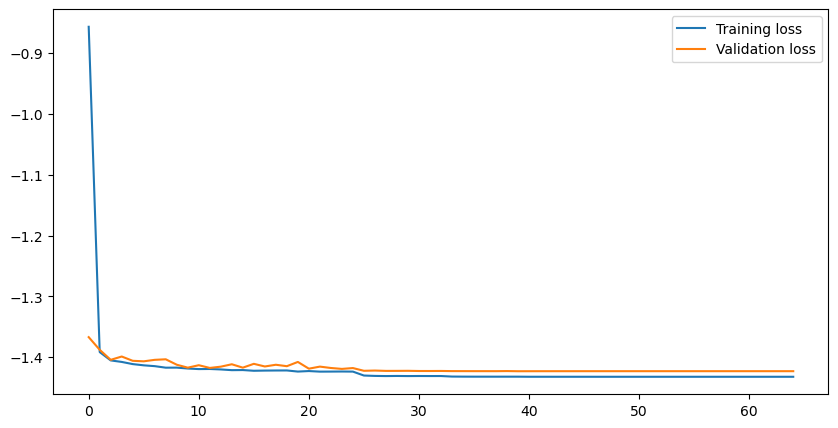

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

In [52]:
y_pred_mixture = mdn_network.predict(x)
print(y_pred_mixture.shape)

3855/3855 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
(123351, 50)


In [58]:
def split_mixture_params(params, output_dim, num_mixes):
    mus = params[: num_mixes * output_dim]
    sigs = params[num_mixes * output_dim : 2 * num_mixes * output_dim]
    pi_logits = params[-num_mixes:]
    return mus, sigs, pi_logits


def softmax(w, t=1.0):
    e = np.array(w) / t  # adjust temperature
    e -= e.max()  # subtract max to protect from exploding exp values.
    e = np.exp(e)
    dist = e / np.sum(e)
    return dist


def sample_from_categorical(dist):
    r = np.random.rand(1)  # uniform random number in [0,1]
    accumulate = 0
    for i in range(0, dist.size):
        accumulate += dist[i]
        if accumulate >= r:
            return i
    tf.logging.info("Error sampling categorical model.")
    return -1


def sample_from_output(params, output_dim, num_mixes, temp=1.0, sigma_temp=1.0):
    mus, sigs, pi_logits = split_mixture_params(params, output_dim, num_mixes)
    pis = softmax(pi_logits, t=temp)
    m = sample_from_categorical(pis)
    # Alternative way to sample from categorical:
    # m = np.random.choice(range(len(pis)), p=pis)
    mus_vector = mus[m * output_dim : (m + 1) * output_dim]
    sig_vector = sigs[m * output_dim : (m + 1) * output_dim]
    scale_matrix = np.identity(output_dim) * sig_vector  # scale matrix from diag
    cov_matrix = np.matmul(scale_matrix, scale_matrix.T)  # cov is scale squared.
    cov_matrix = cov_matrix * sigma_temp  # adjust for sigma temperature
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return sample

In [61]:
y_pred_mixture.shape

(123351, 50)

In [59]:
# Sample from the predicted distributions
y_samples = np.apply_along_axis(
    sample_from_output, 1, y_pred_mixture, 1, N_MIXES, temp=1.0
)

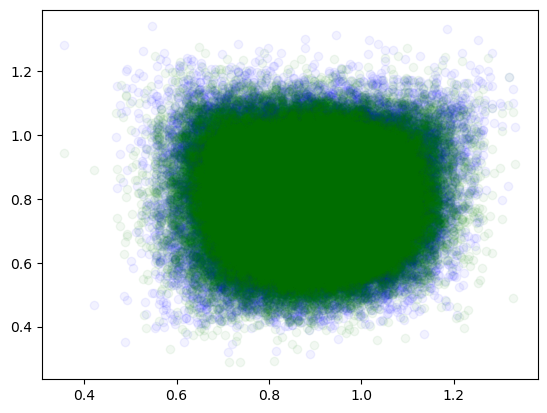

In [60]:
plt.scatter(x, y, alpha=0.05, color="blue", label="Ground Truth")
plt.scatter(
    x,
    y_samples[:, :, 0],
    color="green",
    alpha=0.05,
    label="Mixture Density Network prediction",
)
plt.show()

### Calculate Accomodation Co-efficients for MD and MDN data

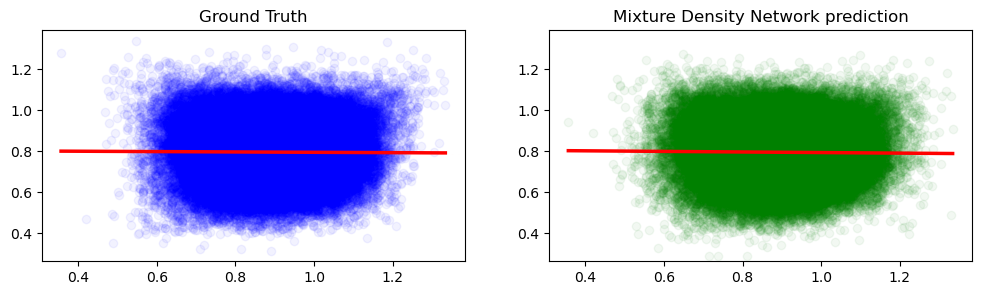

Slope: -0.00876469154707154, Intercept: 0.8039470291828164
Slope: -0.01416168528248291, Intercept: 0.8081159137464817
AC for MD data: 1.0087646915470716, AC for MDN data: 1.0141616852824828


In [61]:
x_org = [i[0] for i in x]
y_org = [i[0] for i in y]
y_pred = [i[0] for i in y_samples[:, :, 0]]

# Regression fit of lines
m_MD, c_MD = np.polyfit(x_org, y_org, deg=1)
m_MDN, c_MDN = np.polyfit(x_org, y_pred, deg=1)


# Plot scatter plots with regression line
xseq = np.linspace(min(x_org), max(x_org), num=100)

fig, axs = plt.subplots(1, 2)
fig.set_figheight(3)
fig.set_figwidth(12)
axs[0].set_title("Ground Truth")
axs[0].scatter(x_org, y_org, alpha=0.05, color="blue")
xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()
axs[0].plot(xseq, c_MD + m_MD * xseq, color="r", lw=2.5)

axs[1].scatter(
    x,
    y_samples[:, :, 0],
    color="green",
    alpha=0.05,
    label="Mixture Density Network prediction",
)
axs[1].set_title("Mixture Density Network prediction")
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
axs[1].plot(xseq, c_MDN + m_MDN * xseq, color="r", lw=2.5)
plt.show()

print(f"Slope: {m_MD}, Intercept: {c_MD}")
print(f"Slope: {m_MDN}, Intercept: {c_MDN}")

# Calculate ACs for MD and MDN data
AC_MD = 1 - m_MD
AC_MDN = 1 - m_MDN
print(f"AC for MD data: {AC_MD}, AC for MDN data: {AC_MDN}")

In [ ]:
# df_results = pd.DataFrame([])
# df_results['v_x_in'] = re_normalize(df_results_norm['v_x_in'], min_max_values.data_min_[0], min_max_values.data_max_[0])
# df_results['v_y_in'] = re_normalize(df_results_norm['v_y_in'], min_max_values.data_min_[1], min_max_values.data_max_[1])
# df_results['v_z_in'] = re_normalize(df_results_norm['v_z_in'], min_max_values.data_min_[2], min_max_values.data_max_[2])
# df_results['v_x_out'] = re_normalize(df_results_norm['v_x_out'], min_max_values.data_min_[3], min_max_values.data_max_[3])
# df_results['v_y_out'] = re_normalize(df_results_norm['v_y_out'], min_max_values.data_min_[4], min_max_values.data_max_[4])
# df_results['v_z_out'] = re_normalize(df_results_norm['v_z_out'], min_max_values.data_min_[5], min_max_values.data_max_[5])
# df_results['v_x_out_pred'] = re_normalize(df_results_norm['v_x_out_pred'], min_max_values.data_min_[3], min_max_values.data_max_[3])
# df_results['v_y_out_pred'] = re_normalize(df_results_norm['v_y_out_pred'], min_max_values.data_min_[4], min_max_values.data_max_[4])
# df_results['v_z_out_pred'] = re_normalize(df_results_norm['v_z_out_pred'], min_max_values.data_min_[5], min_max_values.data_max_[5])

# df_results['omega_1_in'] = re_normalize(df_results_norm['omega_1_in'], min_max_values.data_min_[0], min_max_values.data_max_[0])
# df_results['omega_2_in'] = re_normalize(df_results_norm['omega_2_in'], min_max_values.data_min_[1], min_max_values.data_max_[1])
# df_results['omega_1_out'] = re_normalize(df_results_norm['omega_1_out'], min_max_values.data_min_[2], min_max_values.data_max_[2])
# df_results['omega_2_out'] = re_normalize(df_results_norm['omega_2_out'], min_max_values.data_min_[3], min_max_values.data_max_[3])
# df_results['omega_1_out_pred'] = re_normalize(df_results_norm['omega_1_out_pred'], min_max_values.data_min_[2], min_max_values.data_max_[2])
# df_results['omega_2_out_pred'] = re_normalize(df_results_norm['omega_2_out_pred'], min_max_values.data_min_[3], min_max_values.data_max_[3])

# Creating columns for overall velocities
# df_results['v_y_in_abs'] = np.absolute(df_results["v_y_in"])
# df_results['v_y_out_abs'] = np.absolute(df_results["v_y_out"])
# df_results['v_y_out_abs_pred'] = np.absolute(df_results["v_y_out_pred"])
# df_results['v_in_tot'] = (np.power(df_results["v_x_in"],2)+ np.power(df_results["v_y_in"],2) + np.power(df_results["v_z_in"],2))**0.5
# df_results['v_out_tot'] = (np.power(df_results["v_x_out"],2)+ np.power(df_results["v_y_out"],2) + np.power(df_results["v_z_out"],2))**0.5
# df_results['E_in_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_results["v_x_in"],2)+ np.power(df_results["v_y_in"],2) + np.power(df_results["v_z_in"],2)))
# df_results['E_out_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_results["v_x_out"],2)+ np.power(df_results["v_y_out"],2) + np.power(df_results["v_z_out"],2)))
# df_results['E_out_tot_trans_pred'] = (0.5 * MASS_H2 * (np.power(df_results["v_x_out_pred"],2)+ np.power(df_results["v_y_out_pred"],2) + np.power(df_results["v_z_out_pred"],2)))

